HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Segway vector state')

<Figure size 432x288 with 0 Axes>

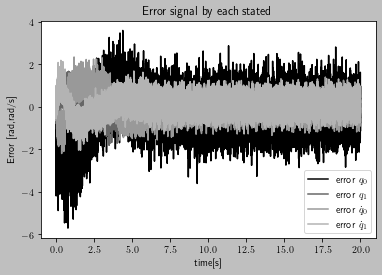

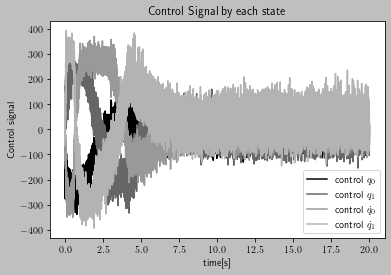

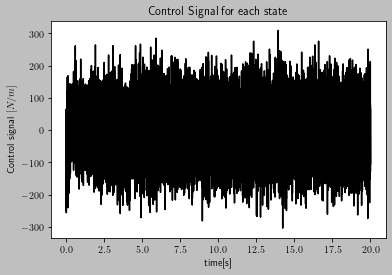

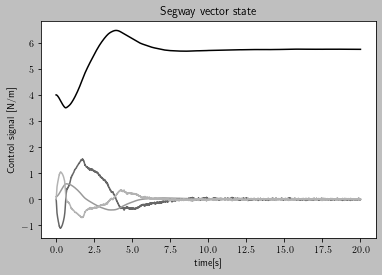

In [4]:
import importlib
import numpy as np
import nengo
import matplotlib.pyplot as plt
import segway; importlib.reload(segway)


estado_inicial = np.array([4.,0., 0.1, 0.])  #condiciones iniciales q
estado_deseado = np.array([6., 0., 0., 0.])

segway_sim = segway.SegwayLink(dt = 1e-3)
segway_sim.init_q = estado_inicial
segway_sim.reset()

model = nengo.Network(seed=0)
with model:
    #creando el nodo del segway
    model.segway_node = segway_sim.create_nengo_node()
    #creando la referencia
    model.ref = nengo.Network('REF')
    with model.ref:
        def PMC_func(t):
            """Devuelve el objetivo final"""
            return estado_deseado
        model.ref.output = nengo.Node(output = PMC_func, label = 'Referencia')

    model.error_q0 = nengo.Ensemble(50,1,radius = 3.1416,label = 'Error q0')
    model.error_dq0 = nengo.Ensemble(50,1,radius = 1)
    model.error_q1 = nengo.Ensemble(100, 1, radius = 1)
    model.error_dq1 = nengo.Ensemble(50,1,radius = 1)

    #envia el estado deseado al nodo error (transform = -1 es para restar x - xd)
    nengo.Connection(model.ref.output[0], model.error_q0, transform = -1)
    nengo.Connection(model.ref.output[1], model.error_dq0, transform = -1)
    nengo.Connection(model.ref.output[2], model.error_q1, transform = -1)
    nengo.Connection(model.ref.output[3], model.error_dq1, transform = -1)
    
    #creando un ensamble que mapee los estados del segway a la red
    model.cerebelo = nengo.Ensemble(1000, 4, radius = 10)
    #conectando la salida del segway al cerebelo
    nengo.Connection(model.segway_node, model.cerebelo)
    #conectando la salida del segway al error
    nengo.Connection(model.cerebelo[0], model.error_q0)
    nengo.Connection(model.cerebelo[1], model.error_dq0)
    nengo.Connection(model.cerebelo[2], model.error_q1)
    nengo.Connection(model.cerebelo[3], model.error_dq1)

    #creando nodos de control individuales
    model.u_q0 = nengo.Ensemble(1000,1, radius = 350)
    model.u_dq0 = nengo.Ensemble(1000,1, radius = 250)
    model.u_q1 = nengo.Ensemble(1000,1, radius = 180)
    model.u_dq1 = nengo.Ensemble(1000,1, radius = 250)
    
    nengo.Connection(model.error_q0, model.u_q0, transform = 100)
    nengo.Connection(model.error_dq0, model.u_dq0, transform = 323.3434)
    nengo.Connection(model.error_q1, model.u_q1, transform = 542.0927)
    nengo.Connection(model.error_dq1, model.u_dq1, transform = 541.08)
    
    nengo.Connection(model.u_q0, model.segway_node[0])
    nengo.Connection(model.u_dq0, model.segway_node[0])
    nengo.Connection(model.u_q1, model.segway_node[0])
    nengo.Connection(model.u_dq1, model.segway_node[0])

    #mandando probes
    data_eq0 = nengo.Probe(model.error_q0)
    data_eq1 = nengo.Probe(model.error_q1)
    data_deq1 = nengo.Probe(model.error_dq1)
    data_deq0 = nengo.Probe(model.error_dq0)
    
    data_uq0 = nengo.Probe(model.u_q0)
    data_uq1 = nengo.Probe(model.u_q1)
    data_udq0 = nengo.Probe(model.u_dq0)
    data_udq1 = nengo.Probe(model.u_dq1)
    
    data_segway = nengo.Probe(model.segway_node)
    

# Check to see if it's open in the GUI

with nengo.Simulator(model) as sim:
    sim.run(20.0)
plt.style.use('grayscale')
plt.rcParams.update({
    "text.usetex": True})
plt.figure()
fig1, (axs1) = plt.subplots(1)
axs1.plot(sim.trange(), sim.data[data_eq0], label = "error $q_0$")
axs1.plot(sim.trange(), sim.data[data_eq1], label = "error $q_1$")
axs1.plot(sim.trange(), sim.data[data_deq0], label = "error $\dot q_0$")
axs1.plot(sim.trange(), sim.data[data_deq1], label = "error $\dot q_1$")
axs1.legend()
axs1.set(xlabel = 'time[s]' , ylabel = 'Error [rad,rad/s]')
axs1.set_title('Error signal by each stated')

fig2, (axs2) = plt.subplots(1)
axs2.plot(sim.trange(), sim.data[data_uq0], label = "control $q_0$")
axs2.plot(sim.trange(), sim.data[data_uq1], label = "control $q_1$")
axs2.plot(sim.trange(), sim.data[data_udq0], label = "control $\dot q_0$")
axs2.plot(sim.trange(), sim.data[data_udq1], label = "control $\dot q_1$")
axs2.set(xlabel = 'time[s]' , ylabel = 'Control signal')
axs2.legend()
axs2.set_title('Control Signal by each state')

fig2a, (axs2a) = plt.subplots(1)
axs2a.plot(sim.trange(), sim.data[data_uq0]+sim.data[data_uq1]+sim.data[data_udq0]+sim.data[data_udq1], label = "Added control")
axs2a.set(xlabel = 'time[s]' , ylabel = 'Control signal $[N/m]$')
axs2a.legend()
axs2a.set_title('Control Signal for each state')

fig3, (axs3) = plt.subplots(1)
axs3.plot(sim.trange(), sim.data[data_segway], label = "u signal")
axs3.set(xlabel = 'time[s]' , ylabel = 'Control signal [N/m]')
axs3.legend(["$q_0$", "$\dot q_0$","$q_1$","$\dot q_1$"])
axs3.set_title('Segway vector state')



   

    




Text(0.5, 1.0, 'Segway vector state')

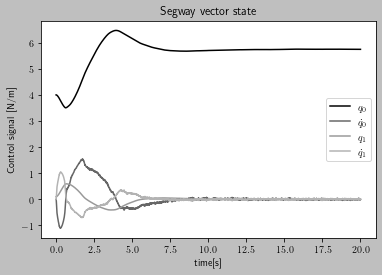

In [7]:
fig4, (axs4) = plt.subplots(1)
axs4.plot(sim.trange(), sim.data[data_segway])
axs4.set(xlabel = 'time[s]' , ylabel = 'Control signal [N/m]')
axs4.legend(["$q_0$", "$\dot q_0$","$q_1$","$\dot q_1$"])
axs4.set_title('Segway vector state')